# Indlæs pakker

In [1]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import numpy as np
import random
import shutil


# Indlæs den rå data

In [2]:
# Den relative sti til ubehandlede billeder
image_folder = os.path.join("..", "Data", "Raw Data", "Sample images")

# Tjek for billeder
image_files = glob.glob(os.path.join(image_folder, "*.png")) + \
              glob.glob(os.path.join(image_folder, "*.jpg")) + \
              glob.glob(os.path.join(image_folder, "*.jpeg"))

# Load images into a dictionary {filename: image_object}
images = {os.path.basename(file): Image.open(file) for file in image_files}

# Print for at se om billederne er indlæst
print(f"Loaded {len(images)} images from {image_folder}: {list(images.keys())}")


Loaded 1351 images from ../Data/Raw Data/Sample images: ['AVI68NCT_lower_combined.png', 'HSY4YB1J_lower_combined.png', '01FJTJU6_upper_combined.png', 'MNIAB8K3_lower_combined.png', 'HPVH85IJ_upper_combined.png', '014JV25R_lower_combined.png', '013NXHPV_upper_combined.png', 'B7ZCYID1_lower_combined.png', '01AKES86_upper_combined.png', 'CYU4HS3D_lower_combined.png', '01K17AN8_upper_combined.png', '3ARXXI22_upper_combined.png', '0169NHT6_upper_combined.png', '019PEUMN_upper_combined.png', '013Z8U5Z_upper_combined.png', '016G9TFH_lower_combined.png', '016X1CJT_lower_combined.png', '4I10EMWA_lower_combined.png', '35XFO1ZF_lower_combined.png', '016PTY8K_lower_combined.png', '01KCA1CT_upper_combined.png', '87ILJ6BK_upper_combined.png', '01A9282X_lower_combined.png', '0140XF2Z_lower_combined.png', '8BA4388V_upper_combined.png', '6BWQC0CT_upper_combined.png', '014ADZ2K_lower_combined.png', 'BIIEY91S_upper_combined.png', '8XVU7PN9_upper_combined.png', '0NH6X4SS_lower_combined.png', 'A9TECAGP_upp

# Display et billede

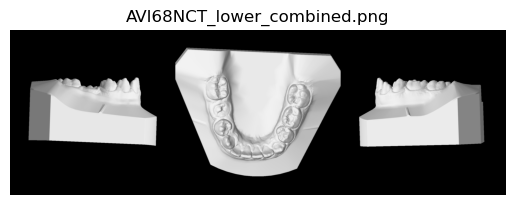

In [3]:
# Display det første billede
if images:
    sample_name, sample_img = next(iter(images.items()))
    plt.imshow(sample_img)
    plt.title(sample_name)
    plt.axis("off")
    plt.show()
else:
    print("No images found. Check the folder path again.")

# Crop og Flip af billeder

In [4]:
# Definer stierne til sample billederne og destinationen for behandlede billeder
source_folder = os.path.join("..", "Data", "Raw Data", "Sample images")
clean_data_folder = os.path.join("..", "Data", "Clean Data")
overbite_folder = os.path.join(clean_data_folder, "Overbite Data")
bolton_folder = os.path.join(clean_data_folder, "Bolton Data")

# Sørg for output folder eksisterer
os.makedirs(clean_data_folder, exist_ok=True)
os.makedirs(overbite_folder, exist_ok=True)
os.makedirs(bolton_folder, exist_ok=True)

# Indlæs billeder
image_files = [f for f in os.listdir(source_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))] # f.lower er bare lowercase

# Tjek dimension
width, height = None, None # Initialisering

for file in image_files:
    image_path = os.path.join(source_folder, file) # Mappe og billede/fil
    img = Image.open(image_path) # Åben billede på overstående image_path
    
    if width is None and height is None:
        width, height = img.size  # Dimension af første billeder (For sammenligning med andre)
    else:
        assert img.size == (width, height), f"Image {file} has different dimensions!" # img (vores billede) .size (Str.) Skal være lig med width og height, fra billede 1

print(f"✅ All images have dimensions: {width}x{height}")

# Opdel billede i 3
split_width = width // 3  # hvert billede får 1/3 af den originale størrelse

for file in image_files:
    image_path = os.path.join(source_folder, file)
    img = Image.open(image_path)
    
    base_name = os.path.splitext(file)[0]

    # Fjern "_combined" hvis det findes
    if "_combined" in base_name:
        base_name = base_name.replace("_combined", "")

    # Undgå gentagelse af suffix
    suffixes = ["lower", "upper", "middle"]
    parts = base_name.split("_")

    if parts[-1] in suffixes:
        suffix = parts[-1]
        base_name = "_".join(parts[:-1])  # Fjern suffix midlertidigt for at undgå gentagelse
    else:
        suffix = ""

    # Crop left, middle, right delene
    left_part = img.crop((0, 0, split_width, height))
    middle_part = img.crop((split_width, 0, 2 * split_width, height))
    right_part = img.crop((2 * split_width, 0, width, height))

    # Flip right billedet
    right_part = right_part.transpose(Image.FLIP_LEFT_RIGHT)

    # Konstruer de rigtige filnavne uden at gentage suffix
    left_filename = f"{base_name}_{suffix}_left.png" if suffix else f"{base_name}_left.png"
    middle_filename = f"{base_name}_{suffix}_middle.png" if suffix else f"{base_name}_middle.png"
    right_filename = f"{base_name}_{suffix}_right.png" if suffix else f"{base_name}_right.png"

    # Gem filerne i de rigtige mapper
    left_part.save(os.path.join(overbite_folder, left_filename))
    middle_part.save(os.path.join(bolton_folder, middle_filename))
    right_part.save(os.path.join(overbite_folder, right_filename))

print(f"✅ Processed {len(image_files)} images and saved to {clean_data_folder}")

✅ All images have dimensions: 3072x1024
✅ Processed 1351 images and saved to ../Data/Clean Data


# CSV filename ændres, og right image koordinater flippes

In [8]:
csv_path = os.path.join("..", "Data", "Raw Data", "Labels as of 28-02-2025 (FINAL - for now).csv") # Originale CSV
output_csv_path = os.path.join("..", "Data", "Clean Data", "Overbite Data", "Updated_Labels.csv") # CSV efter behandling
processed_images_folder = os.path.join("..", "Data", "Clean Data", "Overbite Data") # Behandlede billeder

# Indlæs csv
df = pd.read_csv(csv_path)
df[["X1", "Y1", "X2", "Y2"]] = df[["X1", "Y1", "X2", "Y2"]].astype(int)

sample_image_file = next(iter(os.listdir(processed_images_folder)))
sample_image_path = os.path.join(processed_images_folder, sample_image_file)

with Image.open(sample_image_path) as img:
    image_width, _ = img.size

print(f"✅ Detected image width: {image_width}")

# Opbevar de opdaterede annotationer
updated_annotations = []

# Løb igennem hver række i den Originale CSV
for _, row in df.iterrows():
    filename, x1, y1, x2, y2 = row["Filename"], row["X1"], row["Y1"], row["X2"], row["Y2"]
    
    # Extract base name (Fjerner "_combined.png")
    base_name = filename.replace("_combined.png", "")

    # Definer nye filnavne (Tilføjer _left.png/_right.png til teksten før _combined.png)
    left_filename = f"{base_name}_left.png"
    right_filename = f"{base_name}_right.png"

    # Append left image (X1, Y1 unchanged)
    updated_annotations.append([left_filename, x1, y1]) # Indsætter en række med f"{base_name}_left.png", X-koordinat, Y-koordinat

    # Benyt original billed dim
    original_image_width = 3072  # Eftersom Original CSV annotering var fra den dimension

    # Flip X2 for right image
    flipped_x2 = (original_image_width - 1) - x2

    updated_annotations.append([right_filename, flipped_x2, y2]) # Indsætter en række med f"{base_name}_right.png", X-koordinat (Flipped), Y-koordinat

# Convert to DataFrame and save
updated_df = pd.DataFrame(updated_annotations, columns=["Filename", "X", "Y"])
updated_df.to_csv(output_csv_path, index=False)

print(f"✅ Updated annotations saved to: {output_csv_path}")

✅ Detected image width: 1024
✅ Updated annotations saved to: ../Data/Clean Data/Overbite Data/Updated_Labels.csv


# Formel til koordinat flip

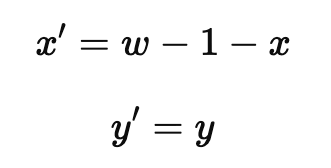

# Eksempel på koordinat flip

So for a point e.g
00OMSZGW_lower_combined.png,777,492,2310,487

We first split the csv data getting:

00OMSZGW_lower_left.png,777,492

00OMSZGW_lower_right.png,2310,487 

And we must alter 00OMSZGW_lower_right.png,2310,487 

So we do:

3072-1-2310=761

Thus having the new x-coordinate


# Gruppering af data

In [ ]:
# Stier til mapper
clean_data_folder = os.path.join("..", "Data", "Clean Data")
overbite_folder = os.path.join(clean_data_folder, "Overbite Data")

# Opret mapper til den nye gruppering
unannotated_folder = os.path.join(overbite_folder, "Unannotated Data")
annotated_folder = os.path.join(overbite_folder, "Annotated Data")
verification_folder = os.path.join(overbite_folder, "Annotated Verification Data")

# Sørg for mapperne eksisterer
os.makedirs(unannotated_folder, exist_ok=True)
os.makedirs(annotated_folder, exist_ok=True)
os.makedirs(verification_folder, exist_ok=True)

# Indlæs CSV-filen med labels
csv_path = os.path.join(clean_data_folder, "Overbite Data", "Updated_Labels.csv")
df = pd.read_csv(csv_path)

# Hent listen af annoterede filnavne
annotated_files = set(df.iloc[:, 0])  # Kolonne 1 indeholder filnavne

# Hent alle billeder fra "Overbite Data"
all_images = [f for f in os.listdir(overbite_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# Del billeder op i annoterede og uannoterede
unannotated_images = [img for img in all_images if img not in annotated_files]
annotated_images = [img for img in all_images if img in annotated_files]

# Flyt uannoterede billeder til "Unannotated Data"
for img in unannotated_images:
    shutil.move(os.path.join(overbite_folder, img), os.path.join(unannotated_folder, img))

# Shuffle annoterede billeder for at gøre fordelingen tilfældig
random.shuffle(annotated_images)

# Beregn opdelingen
split_index = int(len(annotated_images) * 0.8)
annotated_train = annotated_images[:split_index]
annotated_verification = annotated_images[split_index:]

# Flyt billeder til de rigtige mapper
for img in annotated_train:
    shutil.move(os.path.join(overbite_folder, img), os.path.join(annotated_folder, img))

for img in annotated_verification:
    shutil.move(os.path.join(overbite_folder, img), os.path.join(verification_folder, img))

print(f"✅ {len(unannotated_images)} images moved to 'Unannotated Data'")
print(f"✅ {len(annotated_train)} images moved to 'Annotated Data'")
print(f"✅ {len(annotated_verification)} images moved to 'Annotated Verification Data'")

✅ 702 images moved to 'Unannotated Data'
✅ 1600 images moved to 'Annotated Data'
✅ 400 images moved to 'Annotated Verification Data'


# Gruppering af data efter par 

In [9]:
# Stier til mapper
clean_data_folder = os.path.join("..", "Data", "Clean Data")
overbite_folder = os.path.join(clean_data_folder, "Overbite Data")

# Opret mapper til den nye gruppering
unannotated_folder = os.path.join(overbite_folder, "Unannotated Data Pairs")
annotated_folder = os.path.join(overbite_folder, "Annotated Data Pairs")
verification_folder = os.path.join(overbite_folder, "Annotated Verification Data Pairs")

# Sørg for mapperne eksisterer
os.makedirs(unannotated_folder, exist_ok=True)
os.makedirs(annotated_folder, exist_ok=True)
os.makedirs(verification_folder, exist_ok=True)

# Indlæs CSV-filen med labels
csv_path = os.path.join(clean_data_folder, "Overbite Data", "Updated_Labels.csv")
df = pd.read_csv(csv_path)

# Hent listen af annoterede filnavne (uden suffix og filendelse)
def extract_base_name(filename):
    return filename.split("_")[0]  # Tag kun den første del før første underscore

annotated_files = set(extract_base_name(f) for f in df.iloc[:, 0])

# Hent alle billeder fra "Overbite Data"
all_images = [f for f in os.listdir(overbite_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# Organiser billeder i grupper baseret på den fælles del før første underscore
image_groups = {}
for img in all_images:
    base_name = extract_base_name(img)
    if base_name not in image_groups:
        image_groups[base_name] = []
    image_groups[base_name].append(img)

# Del billeder op i annoterede og uannoterede
unannotated_groups = [group for key, group in image_groups.items() if key not in annotated_files]
annotated_groups = [group for key, group in image_groups.items() if key in annotated_files]

# Flyt uannoterede billeder
for group in unannotated_groups:
    for img in group:
        shutil.move(os.path.join(overbite_folder, img), os.path.join(unannotated_folder, img))

# Shuffle annoterede billeder for at gøre fordelingen tilfældig
random.shuffle(annotated_groups)

# Beregn opdelingen
split_index = int(len(annotated_groups) * 0.8)
annotated_train = annotated_groups[:split_index]
annotated_verification = annotated_groups[split_index:]

# Flyt billeder til de rigtige mapper
for group in annotated_train:
    for img in group:
        shutil.move(os.path.join(overbite_folder, img), os.path.join(annotated_folder, img))

for group in annotated_verification:
    for img in group:
        shutil.move(os.path.join(overbite_folder, img), os.path.join(verification_folder, img))

print(f"✅ {sum(len(g) for g in unannotated_groups)} images moved to 'Unannotated Data Pairs'")
print(f"✅ {sum(len(g) for g in annotated_train)} images moved to 'Annotated Data Pairs'")
print(f"✅ {sum(len(g) for g in annotated_verification)} images moved to 'Annotated Verification Data Pairs'")



✅ 36 images moved to 'Unannotated Data Pairs'
✅ 2130 images moved to 'Annotated Data Pairs'
✅ 536 images moved to 'Annotated Verification Data Pairs'


# Video af data

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob

# Stier til mapper
clean_data_folder = os.path.join("..", "Data", "Clean Data")
overbite_folder = os.path.join(clean_data_folder, "Overbite Data")
annotated_folders = [
    os.path.join(overbite_folder, "Annotated Data"),
    os.path.join(overbite_folder, "Annotated Verification Data")
]

# Indlæs CSV-filen med annoteringer
csv_path = os.path.join(clean_data_folder, "Overbite Data", "Updated_Labels.csv")
df = pd.read_csv(csv_path)

# Hent kun de relevante kolonner
image_filenames = df.iloc[:, 0].values  # Kolonne 1: Filnavne
coords = df.iloc[:, 1:].values  # Resten: x, y koordinater

# Opret en liste til video frames
frames = []

# Gennemgå billeder i de annoterede mapper
for folder in annotated_folders:
    image_files = glob.glob(os.path.join(folder, "*.png")) + \
                  glob.glob(os.path.join(folder, "*.jpg")) + \
                  glob.glob(os.path.join(folder, "*.jpeg"))
    
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        
        if img_name not in image_filenames:
            continue  # Spring billeder over, der ikke har annoteringer
        
        # Indlæs billede
        img = Image.open(img_path)
        img = np.array(img)
        
        # Find koordinaterne for dette billede
        index = np.where(image_filenames == img_name)[0][0]
        image_coords = coords[index].reshape(-1, 2)  # Gør dem til (x, y) par
        
        # Plot billede
        fig, ax = plt.subplots()
        ax.imshow(img, cmap='gray')
        ax.scatter(image_coords[:, 0], image_coords[:, 1], c='red', s=1)  # Små prikker
        ax.set_title(f"Filename: {img_name}")
        
        # Tilføj en legend for x-y koordinater
        legend_labels = [f"({int(x)}, {int(y)})" for x, y in image_coords[:5]]  # Vis kun de første 5 for plads
        for i, (x, y) in enumerate(image_coords[:5]):
            ax.text(x, y, legend_labels[i], fontsize=6, color='yellow', ha='right')
        
        ax.axis("off")
        
        # Gem frame som billede
        frame_path = "temp_frame.png"
        plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)

        plt.close()
        
        # Indlæs den gemte frame
        frame = cv2.imread(frame_path)
        frames.append(frame)

# Opret video
video_path = os.path.join(clean_data_folder, "Overbite Data", "annotated_video.mp4")
height, width, _ = frames[0].shape
fps = 5  # Justér efter behov

fourcc = cv2.VideoWriter_fourcc(*'H264')
video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

for frame in frames:
    video.write(frame)

video.release()

os.remove(frame_path) # Slet temp filen
print(f"✅ Video gemt: {video_path}")

✅ Video gemt: ..\Data\Clean Data\annotated_video.mp4
